In [4]:
conda install numpy scipy mkl-service libpython m2w64-toolchain

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\camil\anaconda3

  added / updated specs:
    - libpython
    - m2w64-toolchain
    - mkl-service
    - numpy
    - scipy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    libpython-2.1              |           py38_0          49 KB
    ------------------------------------------------------------
                                           Total:          49 KB

The following NEW packages will be INSTALLED:

  libpython          pkgs/main/win-64::libpython-2.1-py38_0




libpython-2.1        | 49 KB     |            |   0% 
libpython-2.1        | 49 KB     | ###2       |  33% 
libpython-2.1        | 49 KB     | ########## | 100% 
libpython-2.1        | 49 KB     | ########## | 100% 
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...worki

In [ ]:
!pip install emcee
!pip install corner
!pip install pymc


In [1]:
import numpy as np
import matplotlib.pylab as plt
from numpy import math
from scipy.optimize import curve_fit
import seaborn as sns
from scipy import stats
from scipy.stats import *
import pandas as pd
from scipy.optimize import curve_fit
from scipy.optimize import minimize

import emcee
import seaborn as sns
import corner
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [37]:
Dat=np.loadtxt('figure1_plotdata.csv',delimiter=',',skiprows=1)
Names=np.array(['Frequency [MHz]', 'Weight', 'a: Tsky [K]', 'b: Tres1 [K]', 'c: Tres2 [K]','d: Tmodel [K]', 'e: T21 [K]'
])

# los datos de estas constantes estan el kelvin, al igual que los datos tomados de EDGES

#Bow=1570.0/1000, 700.0/1000,-1100.0/1000,750.0/1000,-175.0/1000,0.567,78.3,20.75,800.0,0.05

Bow= 1570, 700,-1100,750,-175,0.530,78.3,20.75,8.0,0.05             # intersección con el eje y
Pyemcee= -11221.09499241, -14168.57143649, -10203.98895781,    144.62969775,12659.42909717,500.0/1000,78.3,19.0,7.0,0.05   #ajuste coeficientes de minimos cuadrados
Pyemcee2=  1743.9711358801117, 147.55004539601418, -685.8034915470453,  36.53665860684164,-196.18414188062908, 0.524285560037914, 78.6235695471557, 21.162879332114997,7.6124372729808196,0.05
Intento= -14285.22801433, -17568.34439754, -12412.45765732,    167.33842652, 15700.28024181, 0.51948421412718, 78.51820480335225, 19.32741526388625, 7.001176416303,0.05
Natu_result= -10111.419 ,-5673.739 ,-1831.621 ,150.673 ,11711.500 ,0.553, 6.78 ,78.31 ,18.74,0.05
Natu= 2000, -720,1000,-720,175,1.12,78.3,19.5,2.8,0.05 
Col=['b','r','darkorange','darkmagenta','gold','g','khaki','r','indigo','teal']
Cons=np.array([Bow,Pyemcee,Pyemcee2,Intento,Natu_result,Natu])
Cons_names=np.array(['Bow','Pyemcee','Pyemcee2','Natu_result','Intento','Natu'])

x,y=Dat[:,0][Dat[:,2]>0],Dat[:,2][Dat[:,2]>0] # Variables
# Datos cortados
x_C,y_C=Dat[:,0][Dat[:,0]>60.0] ,Dat[:,2][Dat[:,0]>60.0] # Variables
x_C,y_C=x_C[x_C<94.0],y_C[x_C<94.0]

"""
Funciones de la temperatura 
Sky
"""
##################################0-
def T_f(v,a0,a1,a2,a3,a4):
  vc=np.median(v) #Frecuancia central
  vc=78.0 # frecuancia central (EDGES) 
  return a0*(v/vc)**-2.5+a1*(v/vc)**-2.5*np.log10(v/vc)+a3*(v/vc)**-4.5+a4*(v/vc)**-2.0+a2*(v/vc)**-2.5*np.log10(v/vc)**2
def T_21(v,A,v0,w,tau):
  B=((4*(v-v0)**2)/(w**2))*(np.log10((-1/tau)*np.log10((1+(np.e**(-tau)))/2)))
  return-A*(1-(np.e**(-tau*(np.e)**(B))))/(1-(np.e**(-tau)))

def T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau):
  T21= T_21(v,A,v0,w,tau)
  Tf= T_f(v,a0,a1,a2,a3,a4)
  return T21+Tf

def T_sky_s(v,a0,a1,a2,a3,a4,A,v0,w,tau,sigma):
  T21= T_21(v,A,v0,w,tau)
  Tf= T_f(v,a0,a1,a2,a3,a4)
  return T21+Tf

##Discrepancia

def disc_sgg_s(ii,samples,x,y,Dsin,Dobs):
  #arreglos vacios para guardad los valores de la discrepancia simulada y observada 
  discs=[] 
  disco=[]

  rej=0 ## Tasa de rechazo
  #samples=rr_s[ii,:,:]#parametros
  #yexp=(samples[i,0]*x+samples[i,3])**2+samples[i,1]**2
  #yexp=np.sqrt(yexp)
  #samples[:,0]
  n_100=len(samples)//10 # Candtidad de elementos a selecionar del nwalkers
  for i in range(n_100):
    # yexp es una arreglo que contiene  
    #yexp=T_sky(x,samples[i,0],samples[i,1],samples[i,2],samples[i,3],samples[i,4],samples[i,5],samples[i,6],samples[i,7],samples[i,8] )
    yexp=(T_sky_s(x,*samples[i]))
    modpar=samples[np.random.randint(len(samples))] # Elige un conjunto de parametos de forma aleatoria de la muestra
    # Con los parametros del modelo, generamos datos sintéticos
    ymod=T_sky_s(x,*modpar) # Tsky modelo
    #ymod=np.sqrt(ymod)
    ysim=np.random.normal(ymod,abs(np.mean(samples[:,9]))) #Generando datos sinteticos
    if np.any(yexp<0)|np.any(ysim<0):
        rej+=1 # this checks if a negative ysim is generated
    else:        
        discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()] # se guardan los valores de la discrepacia simulada (Freeman-Tukey)
        disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()] # Se guadan los valores de la discrepacia observada (Freeman-Tukey)
  print("Rejection rate =",100*rej//n_100,"%") #fraccion de veces que un número negativo fue generado
  if 100*rej//n_100 < 100:
      discs=np.array(discs)
      disco=np.array(disco)
      Dsin[ii]=discs
      Dobs[ii]=disco
      # make the discrepancy plot
      ax.scatter(disco,discs,color='darkblue',alpha=0.4,label=str(ii)+", Bayesian p-value:"+str(np.round((disco<discs).sum()*1./len(disco),2)))
      dmax=np.max(np.hstack((disco,discs)))
      dmin=np.min(np.hstack((disco,discs)))
      ppp=np.linspace(0,dmax+10,2)
      ax.plot(ppp,ppp,c='r')
      ax.set_xlim(dmin,dmax)
      ax.set_ylim(dmin,dmax)
      # the Bayesian "p-value" is the fraction of discrepancy realizations 
      # when the observed discrepancy is lower than the simulated discrepancy
      # ideally this "p-value" should not be close to 0 or 1
      print("Bayesian p-value:", (disco<discs).sum()*1./len(disco))

names=np.array(['a0','a1','a2','a3','a4','A','v0','w','tau'])
ds=pd.read_csv('figure1_plotdata.csv',sep=',')
ds.head()
ds2=ds[ds.iloc[:,2]>1.0] 

# Rango de valores completos

<ipython-input-38-c5677184ba2c>:30: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_pred=pm.sample(N,tune=N)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, w, v0, A, a4, a3, a2, a1, a0]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1396 seconds.
There were 1625 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6814590739790113, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


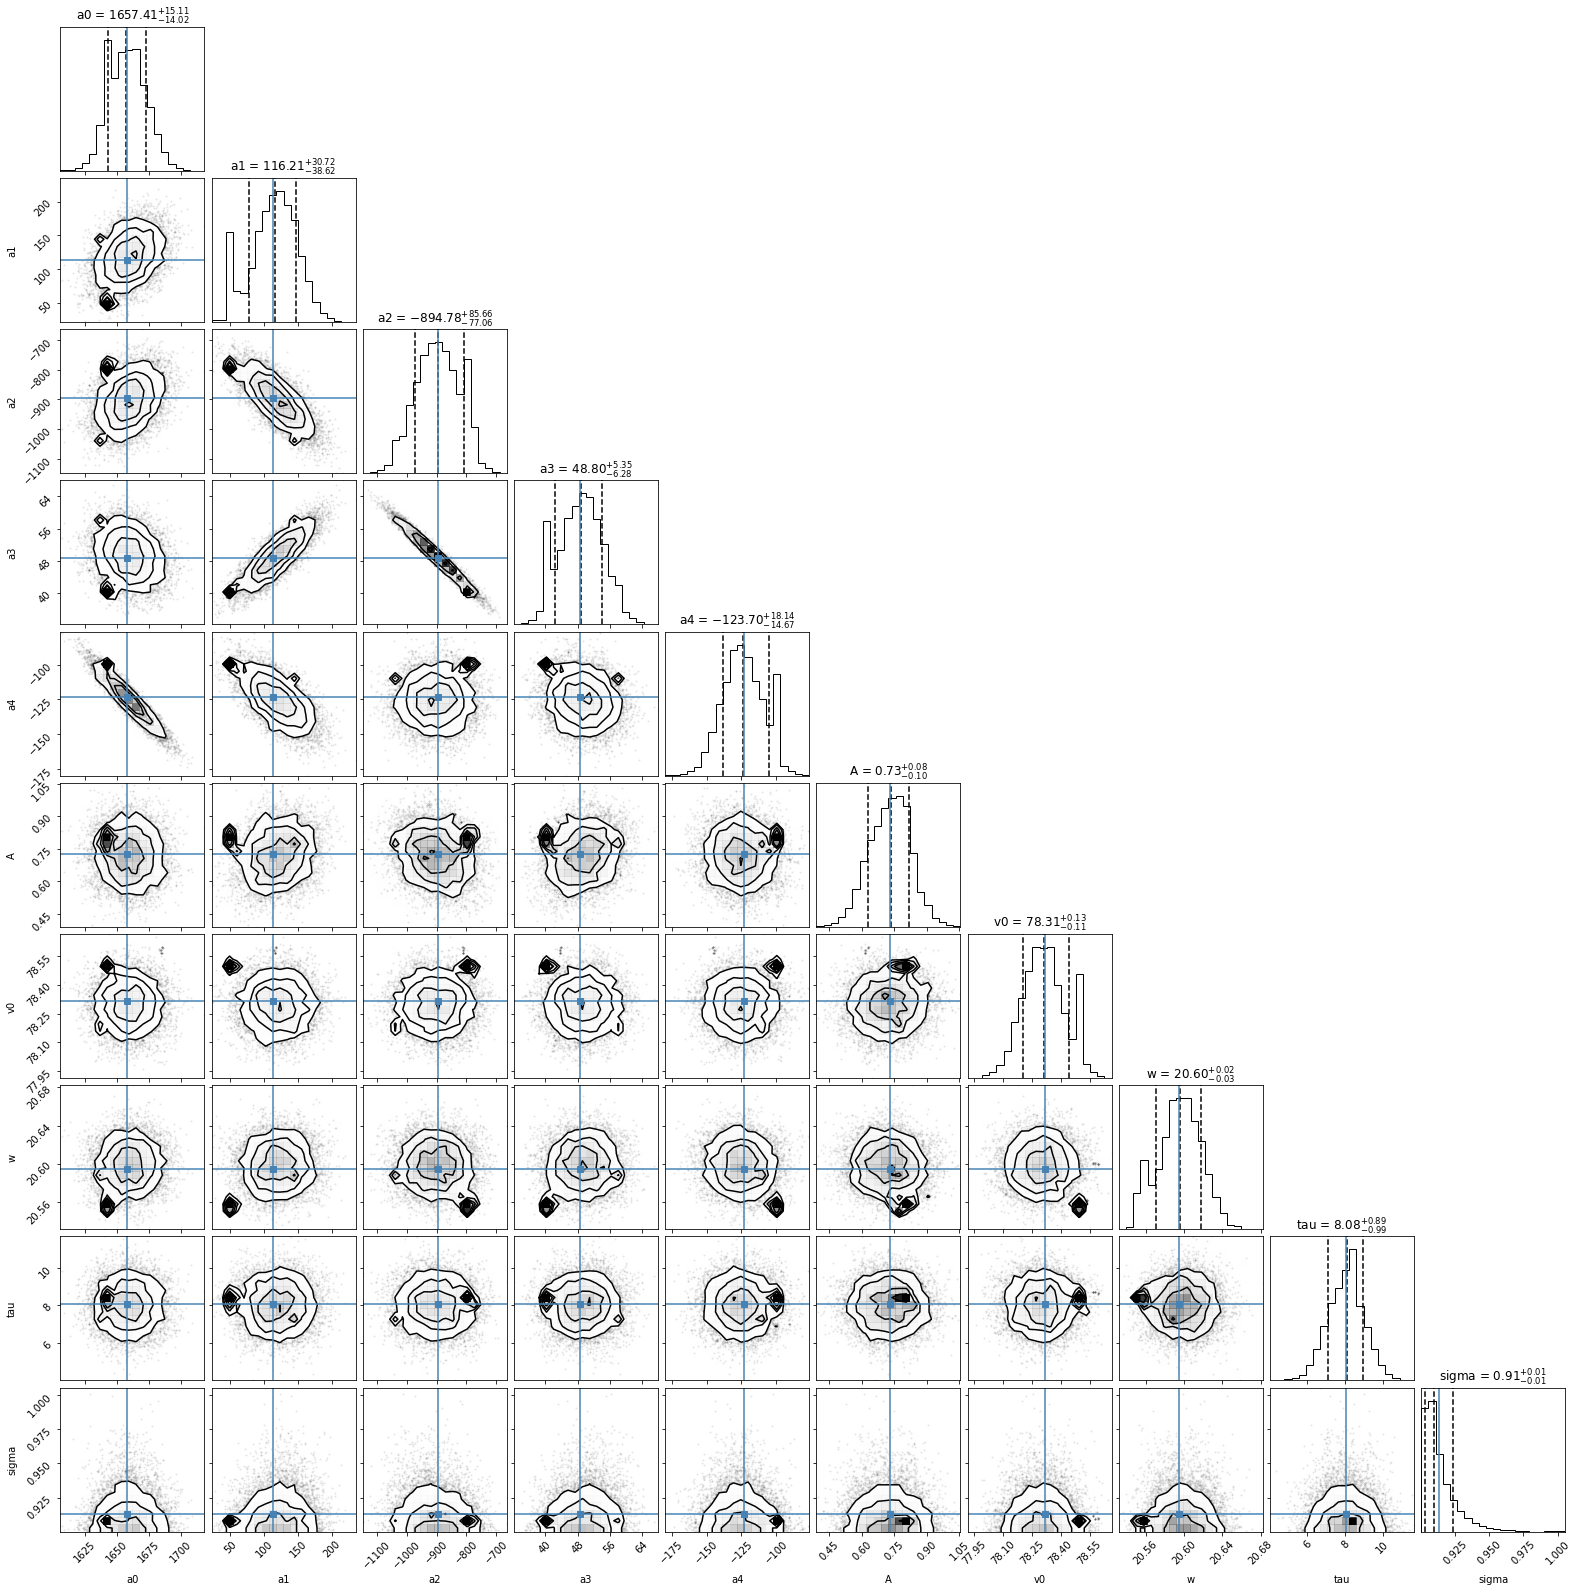

In [38]:
d1=x # Valores de frecuencia [Mhz]
d2=y # Valores de la temperatura [Mk]
N=2000
cc_g31=np.zeros((len(Cons),len(Cons[0])))  # Este arreglo vacio, va a contener los valores principales de los parametros
rr_g31=np.zeros((len(Cons),4*N,len(Cons[0]))) #Este arreglo vacio va a contener los n walkers  de los parametross
#v=d1.freq-d1.freq.mean()/d1.freq.std()
v=d1#.freq
vc=78.0
Nlen=1
for i in range(Nlen):
  a_0,a_1,a_2,a_3,a_4,A_,v_0,w_,tau_,sigma_=Cons[i]
  with pm.Model() as pred_model:
        vc=78.01
        a0=pm.Normal('a0',mu=1590,sd=20)
        a1=pm.Normal('a1',mu=660,sd=80)
        a2=pm.Normal('a2',mu=-1100,sd=100)
        a3=pm.Normal('a3',mu=690,sd=80)
        a4=pm.Normal('a4',mu=-165,sd=20)
    #    TF=(a0*(v)**-2.5+a1*(v)**-2.5*np.log10(v)+a3*(v)**-4.5+a4*(v)**-2.0+a2*(v)**-2.5*np.log10(v)**2)
        A=pm.Normal('A',mu=0.5,sd=0.1)
        v0=pm.Normal('v0',mu=78.3,sd=0.1)
        w=pm.Normal('w',mu=20.6,sd=0.02)
        tau=pm.Normal('tau',mu=8,sd=1.0)
    #    T21=-A*(1-np.e**(tau*np.e**(4*(v-v0)**2/w**2*(np.log10(-1/tau*np.log10((1+np.e**-tau)/2))))))/(1-np.e**-tau)
        B=((4*(v0-v)**2)/(w**2))*(np.log10((-1/tau)*np.log10((1+(np.e**(-tau)))/2)))
        mu=pm.Deterministic('mu',a0*(v/vc)**-2.5+a1*(v/vc)**-2.5*np.log10(v/vc)+a3*(v/vc)**-4.5+a4*(v/vc)**-2.0+a2*(v/vc)**-2.5*np.log10(v/vc)**2  -  A*(1-(np.exp(-tau*np.exp(B))))/(1-(np.e**(-tau))))
    #    mu=pm.Deterministic('mu',T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau))
        sigma=pm.Uniform('sigma',lower=0.9,upper=5.5)
        Tsky=pm.Normal('Tsky',mu=mu,sd=sigma,observed=d2)
        trace_pred=pm.sample(N,tune=N)
  filt1=np.array([np.logical_not('_interval__' in k) for k in trace_pred.varnames])
  filt2=np.array([np.logical_not('mu' in k) for k in trace_pred.varnames])
  vnames=np.array(trace_pred.varnames)[filt1&filt2] # arreglo con los nombres
  trace_array=np.array([trace_pred[i] for i in vnames]).T
  mean_pars=trace_array.mean(axis=0)

  #corner.corner(trace_array,labels=vnames,quantiles=[0.16, 0.5, 0.84],truths=mean_pars,show_titles=True)
  corner.corner(trace_array,labels=vnames,quantiles=[0.16, 0.5, 0.84],truths=trace_array.mean(axis=0),show_titles=True) 
  plt.show()
  cc_g31[i]=mean_pars
  rr_g31[i]=trace_array

# Rango de valores cortados ()

<ipython-input-44-8db97a225e3e>:30: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_pred=pm.sample(N,tune=N)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, w, v0, A, a4, a3, a2, a1, a0]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1552 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 1386 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


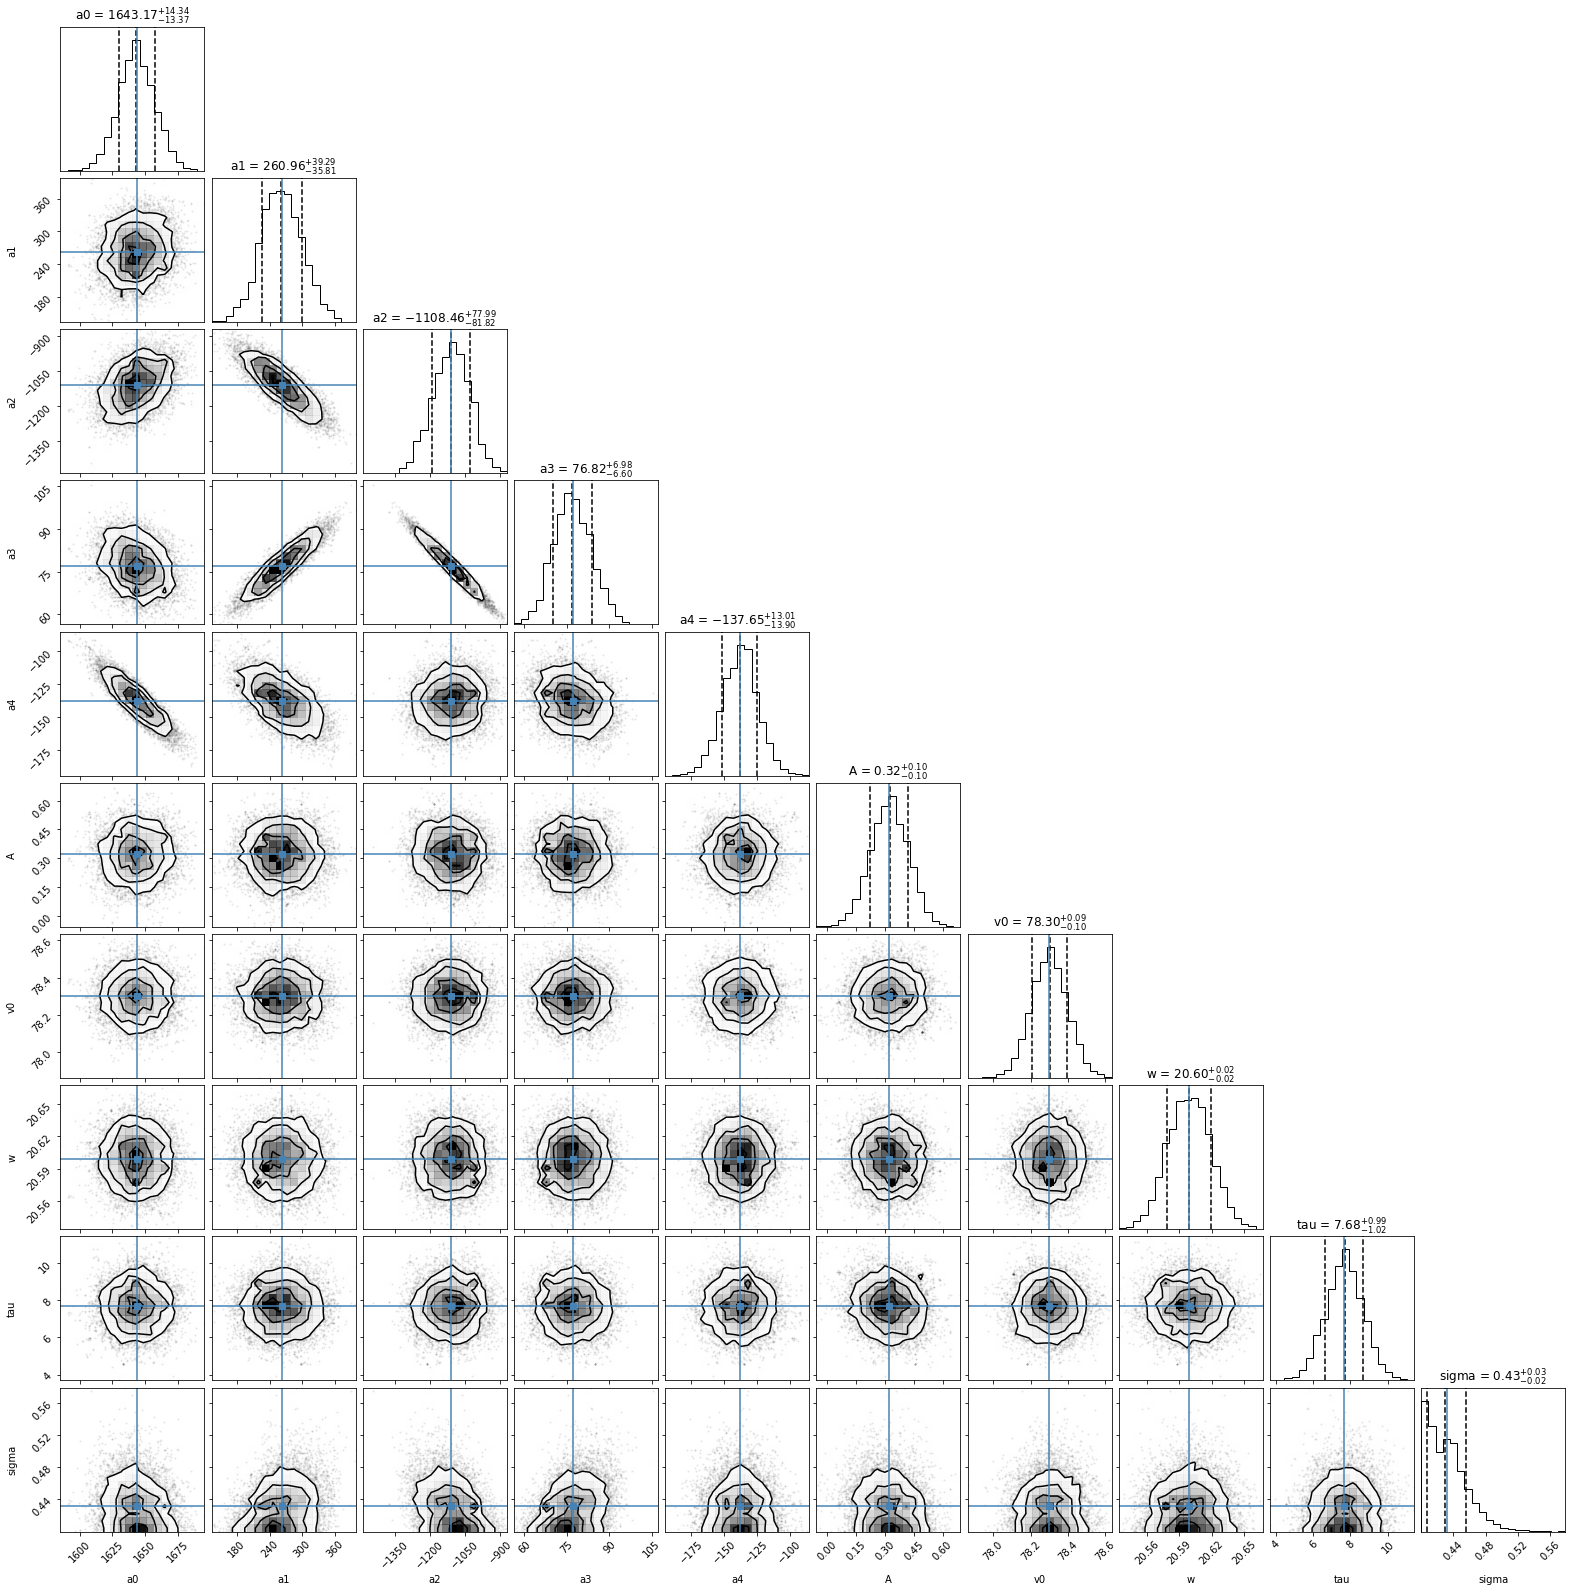

In [44]:
d1=x_C # Valores de frecuencia [Mhz]
d2=y_C # Valores de la temperatura [Mk]
N=2000
cc_g3=np.zeros((len(Cons),len(Cons[0])))  # Este arreglo vacio, va a contener los valores principales de los parametros
rr_g3=np.zeros((len(Cons),4*N,len(Cons[0]))) #Este arreglo vacio va a contener los n walkers  de los parametross
#v=d1.freq-d1.freq.mean()/d1.freq.std()
v=d1#.freq
vc=78.0
Nlen=1
for i in range(Nlen):
  a_0,a_1,a_2,a_3,a_4,A_,v_0,w_,tau_,sigma_=Cons[i]
  with pm.Model() as pred_model:
        vc=78.01
        a0=pm.Normal('a0',mu=1590,sd=20)
        a1=pm.Normal('a1',mu=660,sd=80)
        a2=pm.Normal('a2',mu=-1100,sd=100)
        a3=pm.Normal('a3',mu=690,sd=80)
        a4=pm.Normal('a4',mu=-165,sd=20)
    #    TF=(a0*(v)**-2.5+a1*(v)**-2.5*np.log10(v)+a3*(v)**-4.5+a4*(v)**-2.0+a2*(v)**-2.5*np.log10(v)**2)
        A=pm.Normal('A',mu=0.2,sd=0.1)
        v0=pm.Normal('v0',mu=78.3,sd=0.1)
        w=pm.Normal('w',mu=20.6,sd=0.02)
        tau=pm.Normal('tau',mu=8,sd=1.0)
    #    T21=-A*(1-np.e**(tau*np.e**(4*(v-v0)**2/w**2*(np.log10(-1/tau*np.log10((1+np.e**-tau)/2))))))/(1-np.e**-tau)
        B=((4*(v0-v)**2)/(w**2))*(np.log10((-1/tau)*np.log10((1+(np.e**(-tau)))/2)))
        mu=pm.Deterministic('mu',a0*(v/vc)**-2.5+a1*(v/vc)**-2.5*np.log10(v/vc)+a3*(v/vc)**-4.5+a4*(v/vc)**-2.0+a2*(v/vc)**-2.5*np.log10(v/vc)**2  -  A*(1-(np.exp(-tau*np.exp(B))))/(1-(np.e**(-tau))))
    #    mu=pm.Deterministic('mu',T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau))
        sigma=pm.Uniform('sigma',lower=0.4,upper=1.9)
        Tsky=pm.Normal('Tsky',mu=mu,sd=sigma,observed=d2)
        trace_pred=pm.sample(N,tune=N)
  filt1=np.array([np.logical_not('_interval__' in k) for k in trace_pred.varnames])
  filt2=np.array([np.logical_not('mu' in k) for k in trace_pred.varnames])
  vnames=np.array(trace_pred.varnames)[filt1&filt2] # arreglo con los nombres
  trace_array=np.array([trace_pred[i] for i in vnames]).T
  mean_pars=trace_array.mean(axis=0)

  #corner.corner(trace_array,labels=vnames,quantiles=[0.16, 0.5, 0.84],truths=mean_pars,show_titles=True)
  corner.corner(trace_array,labels=vnames,quantiles=[0.16, 0.5, 0.84],truths=trace_array.mean(axis=0),show_titles=True) 
  plt.show()
  cc_g3[i]=mean_pars
  rr_g3[i]=trace_array

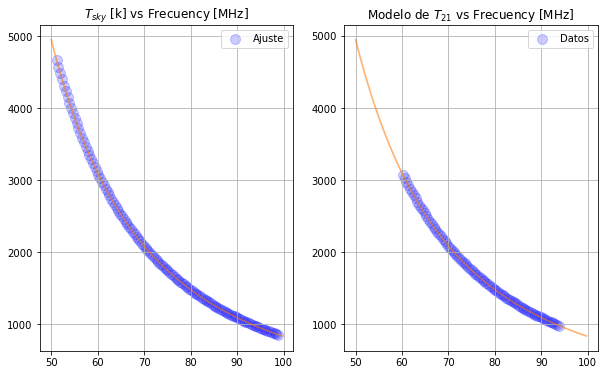

In [46]:
# Datos completos
ii=0
fig, axs = plt.subplots(1, 2,figsize=(10, 6))
axs[0].scatter(x,T_sky_s(x,*cc_g31[ii]),color=Col[ii], label='Ajuste',s=100,alpha=0.2)
for i in range(int(len(rr_g31[ii,:,:])/1000)):
    axs[0].plot(Dat[:,0],T_sky_s(Dat[:,0],*rr_g31[ii,i,:]), "C1", alpha=0.1)
#axs[0].scatter(x_C,y_C,color='black',alpha=0.4,label='Datos')
axs[0].set_title(r'$T_{sky}$ [k] vs Frecuency [MHz] ')


# Datos cortados

axs[1].scatter(x_C,y_C,color='b',alpha=0.2,label='Datos',s=100)
for i in range(int(len(rr_g3[ii,:,:])/1000)):
    axs[1].plot(Dat[:,0],T_sky_s(Dat[:,0],*rr_g3[ii,i,:]), "C1", alpha=0.1)
axs[1].set_title(r'Modelo de $T_{21}$ vs Frecuency [MHz]')

for ax in axs.flat:
  ax.legend()
  ax.grid()

Rejection rate = 0 %
Bayesian p-value: 0.005


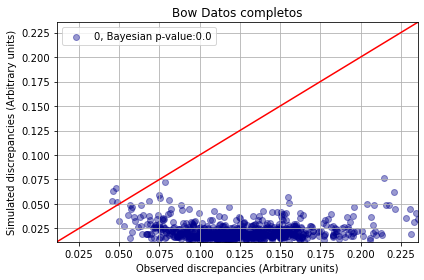

Rejection rate = 0 %
Bayesian p-value: 0.00125


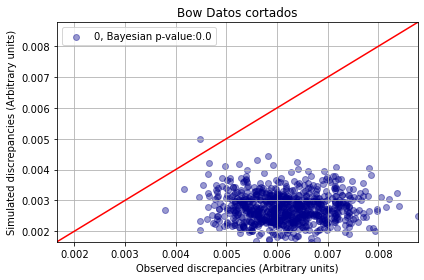

In [47]:
discs=np.zeros((len(Cons),800)) 
disco=np.zeros((len(Cons),800)) 

# Datos completos

fig, ax = plt.subplots()
#for ii, ax in enumerate(axes.flat, start=0):
#for ii in range(len(Cons)):
for ii in range(1):
  disc_sgg_s(ii,rr_g31[ii,:,:],x,y,discs,disco)
  ax.legend(loc='upper left',frameon=True)
  ax.set_xlabel('Observed discrepancies (Arbitrary units)')
  ax.set_ylabel('Simulated discrepancies (Arbitrary units)')
  ax.set_title(Cons_names[ii]+' Datos completos')
  ax.grid()
fig.tight_layout()

plt.show()



#Datos cortados

discs_C=np.zeros((len(Cons),800)) 
disco_C=np.zeros((len(Cons),800)) 



fig, ax = plt.subplots()
#for ii, ax in enumerate(axes.flat, start=0):
#for ii in range(len(Cons)):
for ii in range(Nlen):
  disc_sgg_s(ii,rr_g3[ii,:,:],x_C,y_C ,discs_C,disco_C)
  ax.legend(loc='upper left',frameon=True)
  ax.set_xlabel('Observed discrepancies (Arbitrary units)')
  ax.set_ylabel('Simulated discrepancies (Arbitrary units)')
  ax.set_title(Cons_names[ii]+' Datos cortados')
  ax.grid()
fig.tight_layout()

plt.show()

# Graficas

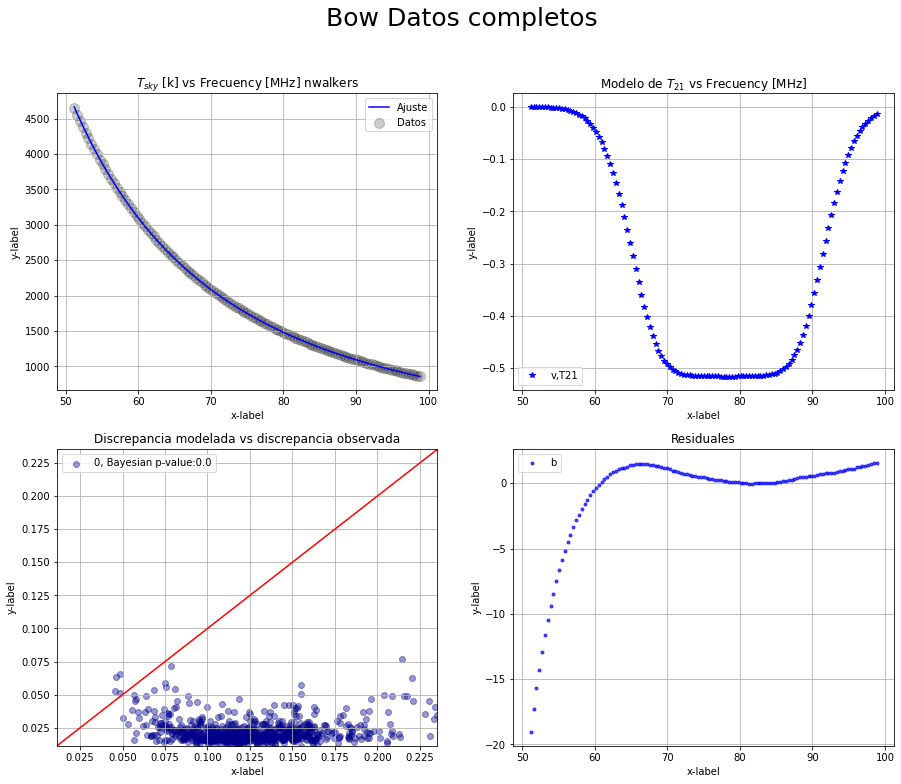

In [48]:
#Datos completa
cc=cc_g31[:,0:9]

for i in range(1):
  fig, axs = plt.subplots(2, 2,figsize=(15, 12))
  fig.suptitle(Cons_names[i] +' Datos completos',fontsize=25)
  a0_,a1_,a2_,a3_,a4_,A1,v01,w1,tau1=cc[i]
  axs[0, 0].plot(x,T_sky(x,*cc[i]),color=Col[i], label='Ajuste')
  axs[0, 0].scatter(x,y,color='black',alpha=0.2,s=100,label='Datos')
  axs[0, 0].set_title(r'$T_{sky}$ [k] vs Frecuency [MHz] nwalkers')


  axs[0, 1].plot(x,T_21(x,A1,v01,w1,tau1),'k*',label='v,T21',color=Col[i])
  axs[0, 1].set_title(r'Modelo de $T_{21}$ vs Frecuency [MHz]')

  axs[1, 0].scatter(disco[i],discs[i],color='darkblue',alpha=0.4,label=str(i)+", Bayesian p-value:"+str(np.round((disco[i]<discs[i]).sum()*1./len(disco[i]),2)))
  dmax=np.max(np.hstack((disco[i],discs[i])))
  dmin=np.min(np.hstack((disco[i],discs[i])))
  ppp=np.linspace(0,dmax+10,2)
  axs[1, 0].plot(ppp,ppp,c='r')
  axs[1, 0].set_title('Discrepancia modelada vs discrepancia observada')
  axs[1, 0].set_xlim(dmin,dmax)
  axs[1, 0].set_ylim(dmin,dmax)


  axs[1, 1].plot(x,(y-T_sky(x ,*cc[i])),'.',alpha=0.7,color=Col[i],label=str(Col[i]))
  axs[1, 1].set_title('Residuales')

  for ax in axs.flat:
      ax.set(xlabel='x-label', ylabel='y-label')

  # Hide x labels and tick labels for top plots and y ticks for right plots.
  for ax in axs.flat:
      ax.legend()
      ax.grid()

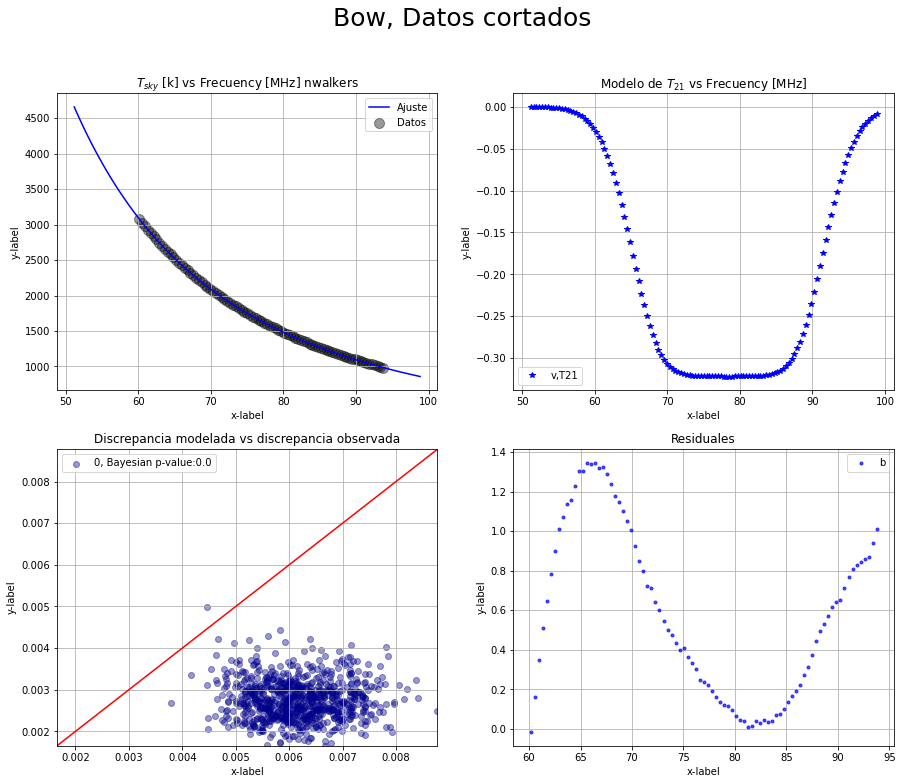

In [51]:
cc_C=cc_g3[:,0:9]
for i in range(1):
  fig, axs = plt.subplots(2, 2,figsize=(15, 12))
  fig.suptitle(Cons_names[i]+', Datos cortados' ,fontsize=25)
  a0_,a1_,a2_,a3_,a4_,A1,v01,w1,tau1=cc_C[i]
  axs[0, 0].plot(x,T_sky(x,*cc_C[i]),color=Col[i], label='Ajuste')
  axs[0, 0].scatter(x_C,y_C,color='black',alpha=0.4,label='Datos',s=100)
  axs[0, 0].set_title(r'$T_{sky}$ [k] vs Frecuency [MHz] nwalkers')


  axs[0, 1].plot(x,T_21(x,A1,v01,w1,tau1),'k*',label='v,T21',color=Col[i])
  axs[0, 1].set_title(r'Modelo de $T_{21}$ vs Frecuency [MHz]')

  axs[1, 0].scatter(disco_C[i],discs_C[i],color='darkblue',alpha=0.4,label=str(i)+", Bayesian p-value:"+str(np.round((disco_C[i]<discs_C[i]).sum()*1./len(disco_C[i]),2)))
  dmax=np.max(np.hstack((disco_C[i],discs_C[i])))
  dmin=np.min(np.hstack((disco_C[i],discs_C[i])))
  ppp=np.linspace(0,dmax+10,2)
  axs[1, 0].plot(ppp,ppp,c='r')
  axs[1, 0].set_title('Discrepancia modelada vs discrepancia observada')
  axs[1, 0].set_xlim(dmin,dmax)
  axs[1, 0].set_ylim(dmin,dmax)


  axs[1, 1].plot(x_C,(y_C-T_sky(x_C ,*cc_C[i])),'.',alpha=0.7,color=Col[i],label=str(Col[i]))
  axs[1, 1].set_title('Residuales')

  for ax in axs.flat:
      ax.set(xlabel='x-label', ylabel='y-label')

  # Hide x labels and tick labels for top plots and y ticks for right plots.
  for ax in axs.flat:
      ax.legend()
      ax.grid()

In [ ]:
d1=x # Valores de frecuencia [Mhz]
d2=y # Valores de la temperatura [Mk]
N=2000
cc_g31=np.zeros((len(Cons),len(Cons[0])))  # Este arreglo vacio, va a contener los valores principales de los parametros
rr_g31=np.zeros((len(Cons),4*N,len(Cons[0]))) #Este arreglo vacio va a contener los n walkers  de los parametross
#v=d1.freq-d1.freq.mean()/d1.freq.std()
v=d1#.freq
vc=78.0
Nlen=1
for i in range(Nlen):
    a_0,a_1,a_2,a_3,a_4,A_,v_0,w_,tau_,sigma_=Cons[i]
with pm.Model() as pred_model:
      vc=78.01
      a0=pm.Normal('a0',mu=1590,sd=20)
      a1=pm.Normal('a1',mu=660,sd=80)
      a2=pm.Normal('a2',mu=-1100,sd=100)
      a3=pm.Normal('a3',mu=690,sd=80)
      a4=pm.Normal('a4',mu=-165,sd=20)
  #    TF=(a0*(v)**-2.5+a1*(v)**-2.5*np.log10(v)+a3*(v)**-4.5+a4*(v)**-2.0+a2*(v)**-2.5*np.log10(v)**2)
      A=pm.Normal('A',mu=0.5,sd=0.1)
      v0=pm.Normal('v0',mu=78.3,sd=0.1)
      w=pm.Normal('w',mu=20.6,sd=0.02)
      tau=pm.Normal('tau',mu=8,sd=1.0)
  #    T21=-A*(1-np.e**(tau*np.e**(4*(v-v0)**2/w**2*(np.log10(-1/tau*np.log10((1+np.e**-tau)/2))))))/(1-np.e**-tau)
      B=((4*(v0-v)**2)/(w**2))*(np.log10((-1/tau)*np.log10((1+(np.e**(-tau)))/2)))
      mu=pm.Deterministic('mu',a0*(v/vc)**-2.5+a1*(v/vc)**-2.5*np.log10(v/vc)+a3*(v/vc)**-4.5+a4*(v/vc)**-2.0+a2*(v/vc)**-2.5*np.log10(v/vc)**2  -  A*(1-(np.exp(-tau*np.exp(B))))/(1-(np.e**(-tau))))
  #    mu=pm.Deterministic('mu',T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau))
      sigma=pm.Uniform('sigma',lower=0.9,upper=5.5)
      Tsky=pm.Normal('Tsky',mu=mu,sd=sigma,observed=d2)
      trace_pred=pm.sample(N,tune=N)
filt1=np.array([np.logical_not('_interval__' in k) for k in trace_pred.varnames])
filt2=np.array([np.logical_not('mu' in k) for k in trace_pred.varnames])
vnames=np.array(trace_pred.varnames)[filt1&filt2] # arreglo con los nombres
trace_array=np.array([trace_pred[i] for i in vnames]).T
mean_pars=trace_array.mean(axis=0)

#corner.corner(trace_array,labels=vnames,quantiles=[0.16, 0.5, 0.84],truths=mean_pars,show_titles=True)
corner.corner(trace_array,labels=vnames,quantiles=[0.16, 0.5, 0.84],truths=trace_array.mean(axis=0),show_titles=True) 
plt.show()
cc_g31[i]=mean_pars
rr_g31[i]=trace_array

<ipython-input-58-0ae1083272b9>:30: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_pred=pm.sample(N,tune=N)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, w, v0, A, a4, a3, a2, a1, a0]


In [ ]:

discs_g31=np.zeros((len(Cons),400)) 
disco_g31=np.zeros((len(Cons),400)) 


#plt.show()

fig, ax = plt.subplots()
#for ii, ax in enumerate(axes.flat, start=0):
#for ii in range(len(Cons)):
for ii in range(Nlen):
  disc_sgg_s(ii,rr_g31[ii,:,:],x,y ,discs_g31,disco_g31)
  ax.legend(loc='upper left',frameon=True)
  ax.set_xlabel('Observed discrepancies (Arbitrary units)')
  ax.set_ylabel('Simulated discrepancies (Arbitrary units)')
  ax.set_title(Cons_names[ii])
  ax.grid()
fig.tight_layout()

plt.show()

for i in range(1):
  fig, axs = plt.subplots(2, 2,figsize=(15, 12))
  fig.suptitle(Cons_names[i],fontsize=25)
  a0_,a1_,a2_,a3_,a4_,A1,v01,w1,tau1,sigma1=cc_g31[i]
  axs[0, 0].plot(x,T_sky_s(x,*cc_g31[i]),color=Col[i], label='Ajuste')
  axs[0, 0].scatter(x,y,color='black',s=120,alpha=0.4,label='Datos')
  axs[0, 0].set_title(r'$T_{sky}$ [k] vs Frecuency [MHz] nwalkers')


  axs[0, 1].plot(x,T_21(x,A1,v01,w1,tau1),'k*',label='v,T21',color=Col[i])
  axs[0, 1].set_title(r'Modelo de $T_{21}$ vs Frecuency [MHz]')

  axs[1, 0].scatter(disco_g31[i],discs_g31[i],color='darkblue',alpha=0.4,label=str(i)+", Bayesian p-value:"+str(np.round((disco_g31[i]<discs_g31[i]).sum()*1./len(disco_g31[i]),2)))
  dmax=np.max(np.hstack((disco_g31[i],discs_g31[i])))
  dmin=np.min(np.hstack((disco_g31[i],discs_g31[i])))
  ppp=np.linspace(0,dmax+10,2)
  axs[1, 0].plot(ppp,ppp,c='r')
  axs[1, 0].set_title('Discrepancia modelada vs discrepancia observada')
  axs[1, 0].set_xlim(dmin,dmax)
  axs[1, 0].set_ylim(dmin,dmax)


  axs[1, 1].plot(x,(y-T_sky_s(x,*cc_g31[i])),'.',alpha=0.7,color=Col[i],label=str(Col[i]))
  axs[1, 1].set_title('Residuales')

  for ax in axs.flat:
      ax.set(xlabel='x-label', ylabel='y-label')

  # Hide x labels and tick labels for top plots and y ticks for right plots.
  for ax in axs.flat:
      ax.legend()
      ax.grid()